# AIR Project
## Group 17

We are using a dataset which includes non-fake as well as fake news (labeled dataset).
https://www.kaggle.com/datasets/saurabhshahane/fake-news-classification


## Imports and specific settings

In [ ]:
import ast
import os.path
import sys
from collections import OrderedDict

import matplotlib
import torch
from torch import nn
from torch.utils.data import DataLoader
from gensim.models import Word2Vec
import multiprocessing
import time
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
from torchmetrics.classification import BinaryF1Score, BinaryRecall, BinaryPrecision, BinaryAccuracy
import string
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from rank_bm25 import BM25Okapi
import math
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix


In [ ]:
## Detecting Fake News via PassiveAggressiveClassifier

In [ ]:
def detect_news(column_name, df):
    labels=df.label
    x_train,x_test,y_train,y_test=train_test_split(df[column_name], labels, test_size=0.2, random_state=7)

    # Initialize a TfidfVectorizer
    tfidf_vectorizer=TfidfVectorizer(stop_words='english', max_df=0.9)

    # Fit and transform train set, transform test set
    tfidf_train=tfidf_vectorizer.fit_transform(x_train)
    tfidf_test=tfidf_vectorizer.transform(x_test)

    # Initialize a PassiveAggressiveClassifier
    pac=PassiveAggressiveClassifier(max_iter=50)
    pac.fit(tfidf_train,y_train)

    # Predict on the test set and calculate accuracy
    y_pred=pac.predict(tfidf_test)
    score=accuracy_score(y_test,y_pred)
    print(f'Accuracy {column_name}: {round(score*100,2)}%')

    # Build confusion matrix
    results = confusion_matrix(y_test,y_pred, labels=[1,0])

    print(f'Results {column_name}: \n true positives: {results[0][0]}\n false negatives: {results[0][1]}\n false positives: {results[1][0]}\n true negatives {results[1][1]}\n')

df=pd.read_csv('data/data.csv')
detect_news('text', df)

detect_news('title', df)

In [378]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
print("running models with {}".format(device))
# device = 'cpu'
if not os.path.exists("data"):
    os.mkdir("data")
if not os.path.exists("figures"):
    os.mkdir("figures")

running models with cuda:0


## Defining Result Dicts

In [379]:
results = {}

def createDictElement(r):
    total_loss, f1, acc, prec, rec, time = r
    tmp = {}
    tmp["total_loss"] = total_loss
    tmp["f1_score"] = f1
    tmp["accuracy"] = acc
    tmp["precision"] = prec
    tmp["recall"] = rec
    tmp["time"] = time
    return tmp

## Loading of dataset and nan-removal
Result is saved in data/data.csv

In [380]:
def pre_process():
    data = pd.read_csv('WELFake_Dataset.csv', index_col=0)
    # display(data[:300])
    for i,x in data.iterrows():
        if len(str(x["text"])) <= 10:
            data.loc[i, "text"] = np.nan
        if len(str(x["title"])) <= 10:
            data.loc[i, "title"] = np.nan

    data.dropna(inplace=True)
    data.reset_index(drop=True, inplace=True)
    data.to_csv("data/data.csv")
    display(data[:300])

In [381]:
if not os.path.exists("data/data.csv"):
    pre_process()

## Tokenization
Result is saved in data/data_token.csv

In [382]:
def tokenize():
    stop = stopwords.words('english')
    stemmer = SnowballStemmer('english')
    punc = [u'\u201c',u'\u201d',u'\u2018',u'\u2019',u'\u2024',u'\u2025',u'\u2026',u'\u2027']
    # print(punc)
    data = pd.read_csv('data/data.csv', index_col=0)
    titles = list()
    texts = list()
    for i, row in data.iterrows():
        title = str(row["title"])
        text = str(row["text"])
        t1 = ""
        for c in title:
            if not (c in string.punctuation or c in punc):
                t1 += c
            else:
                t1 += " "
        t2 = ""
        for c in text:
            if not (c in string.punctuation or c in punc):
                t2 += c
            else:
                t2 += " "
        title_tokens = nltk.tokenize.word_tokenize(t1)
        text_tokens = nltk.tokenize.word_tokenize(t2)
        # title_filtered = [w.lower() for w in title_tokens if not w.lower() in string.punctuation]
        # title_filtered = [w.lower() for w in title_filtered if not w.lower() in punc]
        title_filtered = [w.lower() for w in title_tokens if not w.lower() in stop]
        title_stemmed = [stemmer.stem(w) for w in title_filtered]
        # text_filtered = [w.lower() for w in text_tokens if not w.lower() in string.punctuation]
        # text_filtered = [w.lower() for w in text_filtered if not w.lower() in punc]
        text_filtered = [w.lower() for w in text_tokens if not w.lower() in stop]
        text_stemmed = [stemmer.stem(w) for w in text_filtered]
        # print(title_stemmed)
        # print(text_stemmed)
        titles.append(title_stemmed)
        texts.append(text_stemmed)
        if i % 5000 == 0:
            print(i)
    d = {"title":titles, "text":texts, "label":data["label"]}
    data_cleaned = pd.DataFrame(data=d)
    # data_cleaned["title"] = titles
    # data_cleaned["text"] = texts
    data_cleaned.to_csv("data/data_token.csv")


In [383]:
if not os.path.exists("data/data_token.csv"):
    tokenize()

## Bag of Words


In [384]:
def make_bow(data_path):
    data = pd.read_csv(data_path, index_col=0)
    bow = []
    bow_title = []
    bow_text = []
    bow_both = []
    for i, row in data.iterrows():
        words = row["title"].split(",")
        title = []
        for word in words:
            title.append(str(word).replace("'", "").replace(" ", "").replace("[", "").replace("]", ""))
        words = row["text"].split(",")
        text = []
        for word in words:
            text.append(str(word).replace("'", "").replace(" ", "").replace("[", "").replace("]", ""))
        dic_title = {}
        dic_text = {}
        dic_both = {}
        for word in title:
            if word in dic_title:
                dic_title[word] = dic_title[word] + 1
            else:
                dic_title[word] = 1
            if word in dic_both:
                dic_both[word] = dic_both[word] + 1
            else:
                dic_both[word] = 1
        for word in text:
            if word in dic_text:
                dic_text[word] = dic_text[word] + 1
            else:
                dic_text[word] = 1
            if word in dic_both:
                dic_both[word] = dic_both[word] + 1
            else:
                dic_both[word] = 1
        bow_text.append(dic_text)
        bow_title.append(dic_title)
        bow_both.append(dic_both)
    bow.append(bow_title)
    bow.append(bow_text)
    bow.append(bow_both)
    return bow

In [385]:
# bow = [bow_title[],bow_text[],bow_both[]]
# bow = make_bow('data_tokenized/data_token.csv') # was uncommented

## TFIDF with Cosine

In [386]:
def tf(bow_):
    tf_ = []
    for dic in bow_:
        max_ = 0
        for i in dic:
            if dic[i] > max_:
                max_ = dic[i]
        tf_dic = {}
        for word in dic:
            tf_dic[word] = dic[word]/max_
        tf_.append(tf_dic)
    return tf_

def idf(bow_):
    df_ = {}
    for dic in bow_:
        for word in dic:
            if word in df_:
                df_[word] += 1
            else:
                df_[word] = 1
    idf_ = {}
    for word in df_:
        idf_[word] = math.log10(len(bow)/df_[word])
    return idf_

def tf_idf(bow_):
    tf_ = tf(bow_)
    idf_ = idf(bow_)
    tfidf = []
    for dic in tf_:
        tfidf_dic = {}
        for word in dic:
            tfidf_dic[word] = dic[word] * idf_[word]
        tfidf.append(tfidf_dic)
    return tfidf

def cosineSim(dic_a, dic_b):
    for word in dic_a:
        if word not in dic_b:
            dic_b[word] = 0
    for word in dic_b:
        if word not in dic_a:
            dic_a[word] = 0
    dot, sum_a, sum_b = 0,0,0
    for word in dic_a:
        a = dic_a[word]
        b = dic_b[word]
        dot += (a*b)
        sum_a += math.pow(a,2)
        sum_b += math.pow(b,2)
    sqrt_sum_a = math.sqrt(sum_a)
    sqrt_sum_b = math.sqrt(sum_b)
    return dot / (sqrt_sum_a * sqrt_sum_b)

def tfidf_cosine_ranking(word_, bow_):
    tfidf_all = tf_idf(bow_)
    list_query = [{word_: 1}]
    tfidf_query = tf_idf(list_query)[0]
    article_index = []
    cosSim = []
    cos_index = 0
    for a in tfidf_all:
        article_index.append(cos_index)
        cosSim.append(cosineSim(a,tfidf_query))
        cos_index += 1
    return pd.DataFrame({'article': article_index ,'value': cosSim }).sort_values(by=['value'], ascending=False)



In [387]:
#cos_rank = tfidf_cosine_ranking('obama',bow[2])
#print(cos_rank.head(5))

## bm25

In [388]:
def bm25_ranking(query_,index_):
    data = pd.read_csv('data_tokenized/data_token.csv', index_col=0)
    corpus = []
    title = []
    text = []
    both = []
    for i, row in data.iterrows():
            words = row["title"].split(",")
            for word in words:
                title.append(str(word).replace("'", "").replace(" ", "").replace("[", "").replace("]", ""))
            words = row["text"].split(",")
            for word in words:
                text.append(str(word).replace("'", "").replace(" ", "").replace("[", "").replace("]", ""))
    if index_ == 0:
        corpus = title
    elif index_ == 1:
        corpus = text
    else:
        for i in title:
            both.append(title + text)
        corpus = both

    print("Starting bm25")
    bm25 = BM25Okapi(corpus)
    bm25_scores = bm25.get_scores(query_.split(" "))

    article_index = []
    bm25_index = 0
    for a in bm25_scores:
        article_index.append(bm25_index)
        bm25_index += 1
    return pd.DataFrame({'article': article_index ,'value': bm25_scores }).sort_values(by=['value'], ascending=False)


In [389]:
# bm25_rank = bm25_ranking('sunday',bow[2]) # was uncommented
# print(bm25_rank.head(5)) # was uncommented

## Creating and Training Word2Vec Model

In [390]:
load_model_from_disc = True
w2v_model = None
data = pd.read_csv('data/data_token.csv', index_col=0)
# for i, row in data.iterrows():
#     print(type(row["title"]))
#     print(row)
#     data.loc[i, "title"] = ast.literal_eval(row["title"])
#     data.loc[i, "text"] = ast.literal_eval(row["text"])
if load_model_from_disc:
    try:
        w2v_model = Word2Vec.load("word2vec.model")
    except:
        pass

if w2v_model is None or not load_model_from_disc:
    if load_model_from_disc:
        print("Could not load model from disc. Training model...")
    else:
        print("Loading from disc deactivated. Training model...")

    class MySentences(object):
        def __init__(self, data):
            self.data = data

        def __iter__(self):
            for doc in pd.concat([data["text"], data["title"]]): #change to "title" or combine both
                doc = ast.literal_eval(doc)
                yield doc

    sentences = MySentences(data)

    cores = multiprocessing.cpu_count()
    w2v_model = Word2Vec(min_count=20,
                         window=2,
                         sample=6e-5,
                         alpha=0.03,
                         min_alpha=0.0007,
                         negative=20,
                         workers=cores-1)

    w2v_model.build_vocab(sentences, progress_per=10000)
    t = time.time()
    w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=3, report_delay=1)
    print('Time to train the model: {} mins'.format(round((time.time() - t) / 60, 2)))
    w2v_model.save("word2vec.model")
else:
    print("Model loaded from disc.")

Model loaded from disc.


In [391]:
# calculate similarity
w2v_model.wv.similarity("amazon", 'nazi')

-0.08037868

In [392]:
# calculate similarity
w2v_model.wv.similarity("obama", 'trump')

0.61272305

In [393]:
# find out which element doesn't match
w2v_model.wv.doesnt_match(['amazon', 'obama', 'trump'])

'amazon'

In [394]:
# Which word is to obama as georg is to bush?
w2v_model.wv.most_similar(positive=["obama", "georg"], negative=["bush"], topn=3)

[('barack', 0.5892792344093323),
 ('presid', 0.4774280786514282),
 ('outgo', 0.4366210401058197)]

In [395]:
# e.g. words most similar to obama
w2v_model.wv.most_similar(positive=["obama"])

[('barack', 0.8094509243965149),
 ('presid', 0.664080798625946),
 ('administr', 0.6274117231369019),
 ('predecessor', 0.6216334700584412),
 ('trump', 0.6127229928970337),
 ('undo', 0.5917911529541016),
 ('outgo', 0.5659363865852356),
 ('bush', 0.5520379543304443),
 ('michell', 0.5356377959251404),
 ('bachelet', 0.5156714916229248)]

In [396]:
# e.g. words most similar to obama
w2v_model.wv.most_similar(positive=["presid"])

[('obama', 0.664080798625946),
 ('barack', 0.6538994908332825),
 ('45th', 0.6537858843803406),
 ('trump', 0.6239981651306152),
 ('predecessor', 0.6086247563362122),
 ('donald', 0.6058627963066101),
 ('administr', 0.5998252630233765),
 ('presidenti', 0.5920149087905884),
 ('outgo', 0.5902089476585388),
 ('successor', 0.5844656825065613)]

## Creating Doc2Vec
word2vec for each word with average over document

In [397]:
# creates w2v representation for all documents and titles
def doc2vec():
    titles = list()
    texts = list()
    start = time.time()
    for i, row in data.iterrows():
        vec_title = np.zeros(shape=w2v_model.vector_size)
        vec_text = np.zeros(shape=w2v_model.vector_size)
        tit = ast.literal_eval(row["title"])
        tex = ast.literal_eval(row["text"])
        tit_cnt = 0
        tex_cnt = 0
        for word in tit:
            try:
                vec_title += w2v_model.wv[word]
            except KeyError:
                # print("Didn't find word {}".format(word))
                tit_cnt += 1
                pass
        for word in tex:
            try:
                vec_text += w2v_model.wv[word]
            except KeyError:
                # print("Didn't find word {}".format(word))
                tex_cnt += 1
                pass
        if len(tit) > tit_cnt:
            vec_title /= (len(tit) - tit_cnt)
        if len(tex) > tex_cnt:
            vec_text /= (len(tex) - tex_cnt)
        titles.append(vec_title.tolist())
        texts.append(vec_text.tolist())
        if i % 5000 == 0:
            print("[{}/{}] - {:.1f}s".format(i, len(data.index), time.time() - start))
    end = time.time()
    print("creating doc2vec took {:.1f}s".format(end - start))
    d = {"title":titles, "text":texts, "label":data["label"]}
    data_w2v = pd.DataFrame(data=d)
    data_w2v.to_pickle("data/data_w2v.pkl")
    display(data_w2v[:100])

In [398]:
if not os.path.exists("data/data_w2v.pkl"):
    doc2vec()

## Train-Test-split and Dataloader Creation

In [399]:
def collate_batch(batch):
    labels = list()
    texts = list()
    for (_text, _label) in batch:
        labels.append(_label)
        texts.append(_text)

    return torch.tensor(texts), torch.tensor(labels)

In [400]:
embed_dim = 100
batch_size = 100
params = {'batch_size': batch_size,
          'shuffle': True,
          'num_workers': 0,
          'collate_fn': collate_batch,
          'drop_last': True}


data_d2v = pd.read_pickle("data/data_w2v.pkl")

data_d2v_title = data_d2v[["title", "label"]].copy()
data_d2v_text = data_d2v[["text", "label"]].copy()
X_train_title, X_test_title, y_train_title, y_test_title = train_test_split(data_d2v_title["title"], data_d2v_title["label"], test_size=0.15, random_state=42, shuffle=True)
X_train_text, X_test_text, y_train_text, y_test_text = train_test_split(data_d2v_text["text"], data_d2v_text["label"], test_size=0.15, random_state=42, shuffle=True)

X_train_title.reset_index(drop=True, inplace=True)
X_test_title.reset_index(drop=True, inplace=True)
y_train_title.reset_index(drop=True, inplace=True)
y_test_title.reset_index(drop=True, inplace=True)
X_train_text.reset_index(drop=True, inplace=True)
X_test_text.reset_index(drop=True, inplace=True)
y_train_text.reset_index(drop=True, inplace=True)
y_test_text.reset_index(drop=True, inplace=True)


class data_set(Dataset):
    def __init__(self, X, y):
        super(Dataset, self).__init__()
        assert len(X.index) == len(y.index)
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X.index)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

train_dataset_title = data_set(X_train_title, y_train_title)
test_dataset_title = data_set(X_test_title, y_test_title)
train_dataset_text = data_set(X_train_text, y_train_text)
test_dataset_text = data_set(X_test_text, y_test_text)

train_dataloader_title = DataLoader(train_dataset_title, **params)
test_dataloader_title = DataLoader(test_dataset_title, **params)
train_dataloader_text = DataLoader(train_dataset_text, **params)
test_dataloader_text = DataLoader(test_dataset_text, **params)

## Helper Functions

Progress Bar and Logging

In [401]:
def add_metrics_to_log(log, metrics, y_true, y_pred, prefix=''):
    for metric in metrics:
        q = metric(y_true, y_pred)
        log[prefix + metric.__name__] = q
    return

def log_to_message(log, precision=4):
    fmt = "{0}: {1:." + str(precision) + "f}"
    return "    ".join(fmt.format(k, v) for k, v in log.items())

class ProgressBar(object):
    """Cheers @ajratner"""

    def __init__(self, n, length=40):
        # Protect against division by zero
        self.n      = max(1, n)
        self.nf     = float(n)
        self.length = length
        # Precalculate the i values that should trigger a write operation
        self.ticks = set([round(i/100.0 * n) for i in range(101)])
        self.ticks.add(n-1)
        self.bar(0)

    def bar(self, i, message=""):
        """Assumes i ranges through [0, n-1]"""
        if i in self.ticks:
            b = int(np.ceil(((i+1) / self.nf) * self.length))
            sys.stdout.write("\r[{0}{1}] {2}%\t{3}".format(
                "="*b, " "*(self.length-b), int(100*((i+1) / self.nf)), message
            ))
            sys.stdout.flush()

    def close(self, message=""):
        # Move the bar to 100% before closing
        self.bar(self.n-1)
        sys.stdout.write("\n{0}\n\n".format(message))
        sys.stdout.flush()

## Training Loop

In [402]:
epochs = 10

def train(dataloader, model, loss_fn, optimizer):
    start_time = time.time()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0
    f1 = 0
    precision = 0
    recall = 0
    accuracy = 0
    f1_score_ = BinaryF1Score().to(device)
    precision_ = BinaryPrecision().to(device)
    recall_ = BinaryRecall().to(device)
    accuracy_ = BinaryAccuracy().to(device)
    pb = ProgressBar(size/batch_size)
    log = OrderedDict()
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction error
        X = X.to(device)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y.float())
        total_loss += loss.item()
        f1 += f1_score_(pred.squeeze(), y)
        precision += precision_(pred.squeeze(), y)
        recall += recall_(pred.squeeze(), y)
        accuracy += accuracy_(pred.squeeze(), y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        log['loss'] = float(loss) / (batch + 1)
        log['f1'] = float(f1) / (batch + 1)
        log['accuracy'] = float(accuracy) / (batch + 1) #correct / ((batch + 1) * batch_size)
        log['precision'] = float(precision) / (batch + 1)
        log['recall'] = float(recall) / (batch + 1)
        log['time'] = time.time() - start_time
        pb.bar(batch, log_to_message(log))
    pb.close(log_to_message(log))
    return total_loss, (f1/num_batches).item(), (accuracy/num_batches).item(), (precision/num_batches).item(), (recall/num_batches).item(), time.time()-start_time

## Testing Loop

In [403]:
def test(dataloader, model, loss_fn):
    start_time = time.time()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0
    f1 = 0
    precision = 0
    recall = 0
    accuracy = 0
    f1_score_ = BinaryF1Score().to(device)
    precision_ = BinaryPrecision().to(device)
    recall_ = BinaryRecall().to(device)
    accuracy_ = BinaryAccuracy().to(device)
    pb = ProgressBar(size/batch_size)
    log = OrderedDict()
    model.eval()
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred.squeeze(), y.float())
            f1 += f1_score_(pred.squeeze(), y)
            precision += precision_(pred.squeeze(), y)
            recall += recall_(pred.squeeze(), y)
            accuracy += accuracy_(pred.squeeze(), y)
            # Backpropagation
            log['loss'] = float(test_loss) / (batch + 1)
            log['f1'] = float(f1) / (batch + 1)
            log['accuracy'] = float(accuracy) / (batch + 1) #correct / ((batch + 1) * batch_size)
            log['precision'] = float(precision) / (batch + 1)
            log['recall'] = float(recall) / (batch + 1)
            log['time'] = time.time() - start_time
            pb.bar(batch, log_to_message(log))
    pb.close(log_to_message(log))
    return test_loss.item(), (f1/num_batches).item(), (accuracy/num_batches).item(), (precision/num_batches).item(), (recall/num_batches).item(), time.time()-start_time


## Wrapper for training and testing

In [404]:
def train_and_evaluate(train_dataloader, test_dataloader, model, loss_fn, optimizer, training=True):
    if training:
        for i in range(epochs):
            print("Epoch {}: ------------------------------------------------------------------------------------------------------------------------".format(i+1))
            train(train_dataloader, model, loss_fn, optimizer)
    print("Evaluation ------------------------------------------------------------------------------------------------------------------------")
    return test(test_dataloader, model, loss_fn)

## Simple Model for testing of training loop

In [405]:
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.fc1 = nn.Linear(embed_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, vec):
        x = self.relu(self.fc1(vec))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        return torch.sigmoid(self.fc4(x))

model = SimpleLinearModel().to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

r = train_and_evaluate(train_dataloader_title, test_dataloader_title, model, loss_fn, optimizer)
results["simple_linear_model"] = {}
results["simple_linear_model"]["title"] = createDictElement(r)

model = SimpleLinearModel().to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

r = train_and_evaluate(train_dataloader_text, test_dataloader_text, model, loss_fn, optimizer)
results["simple_linear_model"]["text"] = createDictElement(r)

Epoch 1: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.0006    f1: 0.8513    accuracy: 0.8464    precision: 0.8426    recall: 0.8673    time: 6.8017
loss: 0.0006    f1: 0.8514    accuracy: 0.8467    precision: 0.8428    recall: 0.8674    time: 6.8601

Epoch 2: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.0003    f1: 0.8769    accuracy: 0.8759    precision: 0.8719    recall: 0.8848    time: 6.7999
loss: 0.0006    f1: 0.8767    accuracy: 0.8758    precision: 0.8718    recall: 0.8846    time: 6.8554

Epoch 3: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.0004    f1: 0.8860    accuracy: 0.8850    precision

## Simple Convolutional Model

In [406]:
class SimpleConvolutionModel(nn.Module):
    def __init__(self):
        super(SimpleConvolutionModel, self).__init__()
        self.fc1 = nn.Linear(embed_dim, 100)
        self.conv = nn.Conv2d(in_channels=100, out_channels=100, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=1, stride=1)
        self.fc2 = nn.Linear(100, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.conv(x.unsqueeze(1))
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.squeeze()
        x = torch.sigmoid(self.fc2(x))
        return x


model = SimpleConvolutionModel().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
results["simple_convolution_model"] = {}

r = train_and_evaluate(train_dataloader_title, test_dataloader_title, model, loss_fn, optimizer)
results["simple_convolution_model"]["title"] = createDictElement(r)

model = SimpleConvolutionModel().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
#
r = train_and_evaluate(train_dataloader_text, test_dataloader_text, model, loss_fn, optimizer)
results["simple_convolution_model"]["text"] = createDictElement(r)

Epoch 1: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.3863    f1: 0.6454    accuracy: 0.5048    precision: 0.5049    recall: 0.9024    time: 7.16065
loss: 0.4061    f1: 0.6457    accuracy: 0.5051    precision: 0.5053    recall: 0.9026    time: 7.2125

Epoch 2: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.4243    f1: 0.6206    accuracy: 0.5301    precision: 0.5247    recall: 0.7700    time: 7.49382
loss: 0.3984    f1: 0.6204    accuracy: 0.5301    precision: 0.5246    recall: 0.7696    time: 7.5575

Epoch 3: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.3808    f1: 0.7192    accuracy: 0.7013    precisi

## Bidirectional LSTM model with convolutions

In [407]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.fc1 = nn.Linear(embed_dim, 100)
        # self.embed = nn.Embedding(
        #     num_embeddings=len(w2v_model.wv),
        #     embedding_dim=100)
        self.conv = nn.Conv1d(in_channels=100, out_channels=100, kernel_size=6, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=1)
        # self.fc2 = nn.Linear(95, 1)
        self.lstm = nn.LSTM(96, 32, 3, bidirectional=True)
        self.dropout = nn.Dropout(0.1)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(self.conv(x))
        x = self.maxpool(x)
        x = x.squeeze()
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))

        return x


model = LSTM().to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())
results["lstm_model"] = {}

r = train_and_evaluate(train_dataloader_title, test_dataloader_title, model, loss_fn, optimizer)
results["lstm_model"]["title"] = createDictElement(r)

model = LSTM().to(device)

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

r = train_and_evaluate(train_dataloader_text, test_dataloader_text, model, loss_fn, optimizer)
results["lstm_model"]["text"] = createDictElement(r)



Epoch 1: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.0012    f1: 0.5279    accuracy: 0.5021    precision: 0.5076    recall: 0.6897    time: 10.5764
loss: 0.0012    f1: 0.5288    accuracy: 0.5021    precision: 0.5075    recall: 0.6912    time: 10.6647

Epoch 2: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.0007    f1: 0.6847    accuracy: 0.6806    precision: 0.6839    recall: 0.7064    time: 10.2627
loss: 0.0009    f1: 0.6854    accuracy: 0.6814    precision: 0.6844    recall: 0.7070    time: 10.3711

Epoch 3: ------------------------------------------------------------------------------------------------------------------------
[========================================] 100%	oss: 0.0006    f1: 0.8131    accuracy: 0.8117    preci

## Support Vector Machine

Using a support vector machine (SVM) to label between fake and real news.
First we are using the text as input afterwards just the titles.

In [408]:
def svm(X_train_data, y_train_data, X_test_data, y_test_data):
    X_train = X_train_data.tolist()
    X_test = X_test_data.tolist()
    start_time = time.time()
    clf = SVC(kernel='rbf')
    print("fitting...")
    clf.fit(X_train,y_train_data)
    print("predicting...")
    y_pred = clf.predict(X_test)
    return 0, f1_score(y_test_data,y_pred), accuracy_score(y_test_data, y_pred), precision_score(y_test_data, y_pred), recall_score(y_test_data, y_pred), time.time()-start_time


In [409]:
r = svm(X_train_text, y_train_text, X_test_text, y_test_text)
loss, f1_score_text, accuracy_text, precision_text, recall_text, time_text = r
print("Accuracy for text: {:.2f}%\nF1 score for text: {:.2f}%\nPrecision score for text: {:.2f}%\nRecall score for text: {:.2f}%".format(accuracy_text*100, f1_score_text*100, precision_text*100, recall_text*100))
results["support_vector_machine"] = {}
results["support_vector_machine"]["text"] = createDictElement(r)

fitting...
predicting...
Accuracy for text: 91.46%
F1 score for text: 91.60%
Precision score for text: 91.42%
Recall score for text: 91.79%


In [410]:
r = svm(X_train_title, y_train_title, X_test_title, y_test_title)
loss, f1_score_title, accuracy_title, precision_title, recall_title, time_title = r
print("Accuracy for title: {:.2f}%\nF1 score for title: {:.2f}%\nPrecision score for title: {:.2f}%\nRecall score for title: {:.2f}%".format(accuracy_title*100, f1_score_title*100, precision_title*100, recall_title*100))
results["support_vector_machine"]["title"] = createDictElement(r)

fitting...
predicting...
Accuracy for title: 89.93%
F1 score for title: 90.18%
Precision score for title: 89.26%
Recall score for title: 91.12%


## Random Forest Algorithm

Using the random forest algorithm (RF) to label between fake and real news.
First we are using the text as input afterwards just the titles.

In [411]:
def random_forest(X_train, X_test, y_train, y_test, name, crit='gini'):
    start_time = time.time()
    rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, verbose=0, n_jobs=-1, criterion=crit)
    rf.fit(X_train.tolist(), y_train.tolist())
    y_pred = rf.predict(X_test.tolist())
    acc = accuracy_score(y_test.tolist(), y_pred)
    f1 = f1_score(y_test.tolist(), y_pred)
    prec = precision_score(y_test.tolist(), y_pred)
    rec = recall_score(y_test.tolist(), y_pred)
    print("accuracy for random forest with {} criterion {}: {:.2f}%".format(crit, name, acc*100))
    print("f1 score for random forest with {} criterion{}: {:.2f}%".format(crit, name, f1*100))
    print("precision score random forest with {} criterion for {}: {:.2f}%".format(crit, name, prec*100))
    print("recall score for random forest with {} criterion {}: {:.2f}%".format(crit, name, rec*100))
    return 0, f1, acc, prec, rec, time.time()-start_time

results["random_forest"] = {}
r = random_forest(X_train_text, X_test_text, y_train_text, y_test_text, "w2v text")
results["random_forest"]["text"] = createDictElement(r)
r = random_forest(X_train_title, X_test_title, y_train_title, y_test_title, "w2v title")
results["random_forest"]["title"] = createDictElement(r)

accuracy for random forest with gini criterion w2v text: 91.34%
f1 score for random forest with gini criterionw2v text: 91.60%
precision score random forest with gini criterion for w2v text: 90.17%
recall score for random forest with gini criterion w2v text: 93.07%
accuracy for random forest with gini criterion w2v title: 88.48%
f1 score for random forest with gini criterionw2v title: 88.70%
precision score random forest with gini criterion for w2v title: 88.35%
recall score for random forest with gini criterion w2v title: 89.04%


In [412]:
print(results)

{'simple_linear_model': {'title': {'total_loss': 28.502521514892578, 'f1_score': 0.8923617005348206, 'accuracy': 0.8916038274765015, 'precision': 0.8946155905723572, 'recall': 0.8923699259757996, 'time': 1.2676112651824951}, 'text': {'total_loss': 22.368078231811523, 'f1_score': 0.9194207787513733, 'accuracy': 0.9168869853019714, 'precision': 0.8983998894691467, 'recall': 0.9431520700454712, 'time': 1.2444045543670654}}, 'simple_convolution_model': {'title': {'total_loss': 23487.271484375, 'f1_score': 0.8611519932746887, 'accuracy': 0.857358455657959, 'precision': 0.8478049635887146, 'recall': 0.8771551847457886, 'time': 1.350961446762085}, 'text': {'total_loss': 23458.53515625, 'f1_score': 0.8659823536872864, 'accuracy': 0.8596227765083313, 'precision': 0.8360778093338013, 'recall': 0.9008345603942871, 'time': 1.715757131576538}}, 'lstm_model': {'title': {'total_loss': 31.394250869750977, 'f1_score': 0.8746424317359924, 'accuracy': 0.873867928981781, 'precision': 0.8708183765411377, '

## Prinicipal Component Analysis

### PCA is done to be able to display the distribution of the real and fake news data

In [413]:
def pca_(X_test, y_test, name):
    pca = PCA()
    pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
    plt.figure(figsize=(8, 6))
    Xt = pipe.fit_transform(X_test.tolist())
    plot = plt.scatter(Xt[:,0], Xt[:,1], c=y_test.tolist(), alpha=0.6, s=0.9, cmap='PiYG')
    plt.legend(handles=plot.legend_elements()[0], labels=["real news", "fake news"])
    plt.suptitle("PCA of all {}s".format(name))
    plt.savefig("figures/pca_{}.png".format(name))

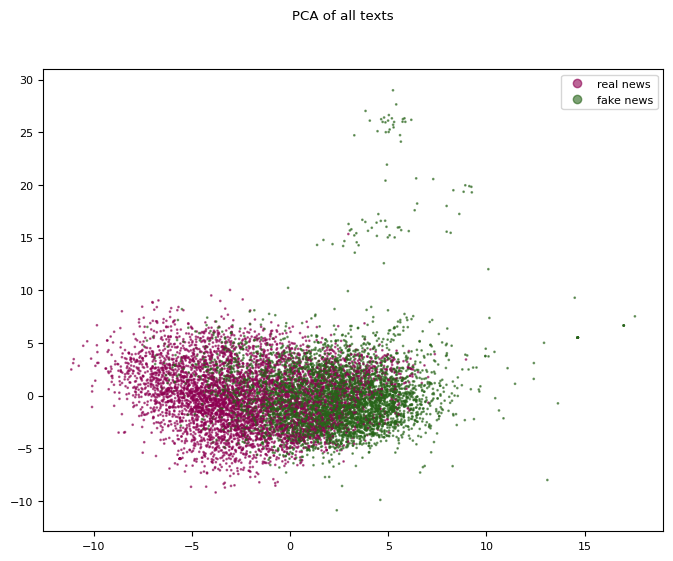

In [414]:
pca_(X_test_text, y_test_text, "text")

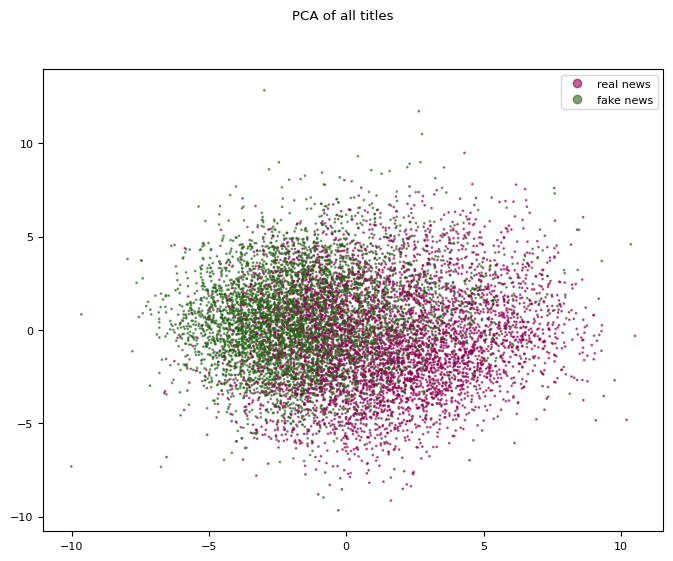

In [415]:
pca_(X_test_title, y_test_title, "title")

## Word Clouds

### Word Clouds of the most common words are created to visualize the data

In [416]:
def wc(label):
    data_pre = pd.read_csv("data_tokenized/data_token_no_stem.csv", index_col=0)
    data_pre_real = data_pre.loc[data_pre["label"] == label]
    data_pre = None
    x = ""
    for i, vals in data_pre_real.iterrows():
        for val in ast.literal_eval(vals["title"]):
            x += " "
            x += val
        # if i % 1000 == 0:
        #     print(i)

    wordcloud = WordCloud(max_font_size=100, max_words=75, background_color="white", width=600, height=400, colormap='tab20b').generate(x)
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

    plt.savefig("figures/word_cloud_{}.png".format("real" if label == 1 else "fake"))

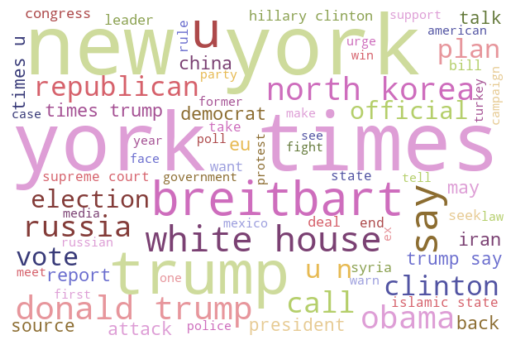

In [417]:
wc(0)

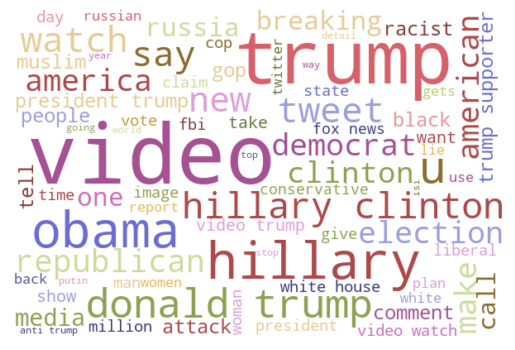

In [418]:
wc(1)

## Number of Occurences of real and fake news articles plot

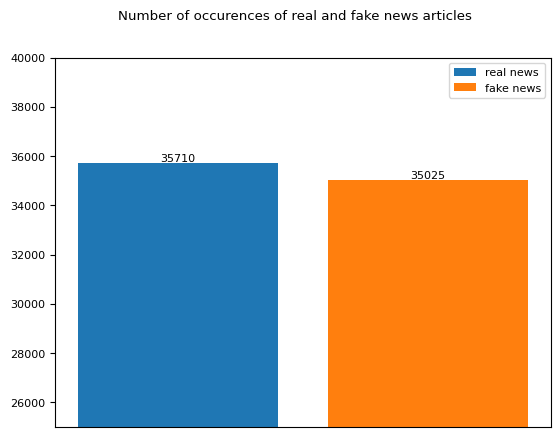

In [419]:
data_pre = pd.read_csv("data_tokenized/data_token_no_stem.csv", index_col=0)
data_pre_real = len(data_pre.loc[data_pre["label"] == 1].index)
data_pre_fake = len(data_pre.loc[data_pre["label"] == 0].index)

fig, ax = plt.subplots()
bars = ax.bar(0, data_pre_real)
ax.bar_label(bars)
bars = ax.bar(1, data_pre_fake)
ax.bar_label(bars)
ax.set_ylim(25000, 40000)
ax.set_xticks([])
plt.suptitle("Number of occurences of real and fake news articles")
plt.legend(labels=["real news", "fake news"])
plt.savefig("figures/num_of_occurrences")

## Plotting Results
### Compare Scores between algorithms (F1-Score and Accuracy)

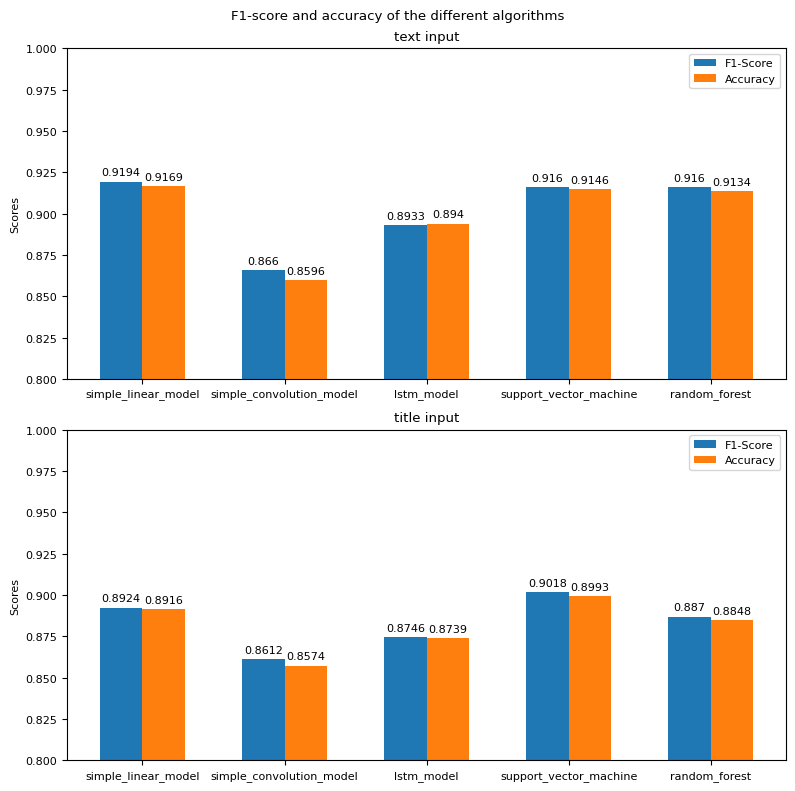

In [420]:
matplotlib.rcParams.update({'font.size': 8})
fig, ax = plt.subplots(2, figsize=(8,8))
plt.suptitle("F1-score and accuracy of the different algorithms")
width = 0.3  # the width of the bars

def setSubplots1(input, axis_x):
    ax[axis_x].set_ylim(0.8, 1.0)
    algorithms = []
    f1s = []
    accs = []
    for element in results:
        algorithms.append(element)
        f1s.append(round(results[element][input]["f1_score"],4))
        accs.append(round(results[element][input]["accuracy"],4))

    x = np.arange(len(algorithms))  # the label locations

    rects1 = ax[axis_x].bar(x - width/2, f1s, width, label='F1-Score')
    rects2 = ax[axis_x].bar(x + width/2, accs, width, label='Accuracy')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[axis_x].set_ylabel('Scores')
    ax[axis_x].set_title(input + ' input')
    ax[axis_x].set_xticks(x, algorithms)
    ax[axis_x].legend()

    ax[axis_x].bar_label(rects1, padding=3)
    ax[axis_x].bar_label(rects2, padding=3)

setSubplots1("text", 0)
setSubplots1("title", 1)

fig.tight_layout()

plt.savefig("figures/Comparison_algorithms")

### Compare scores between different inputs (text and title)

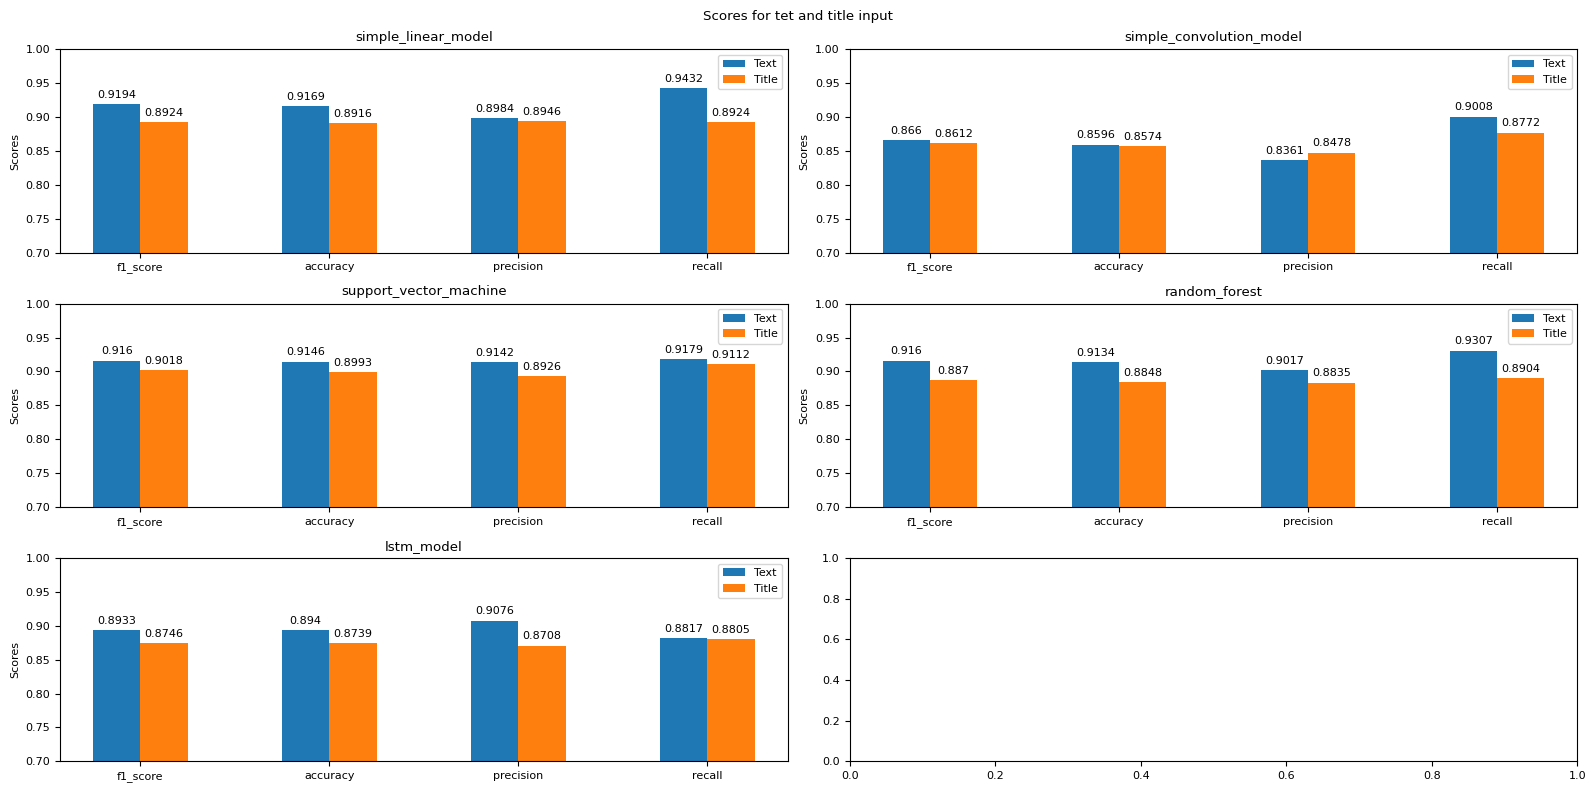

In [421]:
scores = ["f1_score", "accuracy", "precision", "recall"]
x = np.arange(len(scores))  # the label locations
width = 0.25  # the width of the bars
fig, ax = plt.subplots(3, 2, figsize=(16,8))
plt.suptitle("Scores for tet and title input")

def setSubplot(algorithm, axis_x, axis_y):
    title_values = []
    text_values = []
    for element in results[algorithm]["text"]:
        text_values.append(round(results[algorithm]["text"][element],4))
    for element in results[algorithm]["title"]:
        title_values.append(round(results[algorithm]["title"][element],4))
    title_values.pop()
    text_values.pop()
    title_values.pop(0)
    text_values.pop(0)

    rects1 = ax[axis_x][axis_y].bar(x - width/2, text_values, width, label='Text')
    rects2 = ax[axis_x][axis_y].bar(x + width/2, title_values, width, label='Title')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax[axis_x][axis_y].set_ylabel('Scores')
    ax[axis_x][axis_y].set_title(algorithm)
    ax[axis_x][axis_y].set_xticks(x, scores)
    ax[axis_x][axis_y].legend()

    ax[axis_x][axis_y].bar_label(rects1, padding=3)
    ax[axis_x][axis_y].bar_label(rects2, padding=3)
    ax[axis_x][axis_y].set_ylim(0.7, 1.0)

setSubplot("simple_linear_model", 0, 0)
setSubplot("simple_convolution_model", 0, 1)
setSubplot("support_vector_machine", 1, 0)
setSubplot("random_forest", 1, 1)
setSubplot("lstm_model", 2, 0)

fig.tight_layout()

plt.savefig("figures/Comparison_input")
